#  Airbnb a Berlino
### *Data processing e exploratory data analytics sulle attività di Airbnb a Berlino.*
Airbnb è un portale online che mette in contatto persone in cerca di un alloggio o di una camera per brevi periodi,
con persone che dispongono di uno spazio extra da affittare, generalmente privati.

Ad oggi Airbnb offre alloggi in oltre **26.000 città** in **192 paesi** con più di **10 milioni di notti prenotate**
in tutto il mondo. <br>
Gli annunci includono sistemazioni quali stanze private, interi appartamenti, castelli e ville,
ma anche barche, baite, case sugli alberi, igloo, isole private e qualsiasi altro tipo di alloggio.
<br>
Per questa esercitazione di Big Data analizzeremo come Airbnb si sia insediato nel settore dell'ospitalità e in
particolare a __Berlino__, uno dei mercati più caldi per Airbnb in Europa, con oltre 22.552 annunci a novembre 2018.
<br>
I dati utilizzati per questa esercitazione sono stati estratti nel __2018__ e contengono dati su:
- __listing__: dati su gli annunci a Berlino;
- __listing_summary__: dati aggiuntive riguardo gli annunci;
- __calendar_summary__: dati dettagliati del calendario per le inserzioni a Berlino.

<br>
Il dataset è disponibile al seguente sito: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data

## Importiamo i pacchetti necessari per questa esercitazione.

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd


pd.__version__

'1.2.0'

## 1 Il dataset

Il dataset è composto da 7 file.<br>
L'identificatore univoco nel set di dati è l'__id__ di __*listing*__,
che sostanzialmente è l'id relativo all'annuncio.

In [46]:
import os
print(os.listdir('airbnbDataset'))

['reviews.csv', 'neighbourhoods.csv', 'listings.csv', 'calendar_summary.csv', 'reviews_summary.csv', 'listings_summary.csv']


In [47]:
listing = pd.read_csv('airbnbDataset/listings.csv', index_col='id')
listing_summary = pd.read_csv('airbnbDataset/listings_summary.csv', index_col='id')
calendar = pd.read_csv('airbnbDataset/calendar_summary.csv', index_col=['listing_id'])
reviews_summary = pd.read_csv('airbnbDataset/reviews_summary.csv', index_col=['date'])

/Users/francescofranco/PycharmProjects/DataAnalytics/venv/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### 1.2 Verifichiamo le dimensioni del dataframe listing

In [48]:
print(listing.shape)

(22552, 15)


### 1.3 Verifichiamo le colonne che compongono il dataframe listing

In [49]:
print(listing.columns)

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


### 1.4 Verifichiamo le dimensioni del dataframe listing_summary

In [50]:
print(listing_summary.shape)
print(listing_summary.columns)

(22552, 95)
Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathr

Il dataframe *listing_summary* contiene 95 variabili. Per questa esercitazione terrò solo le variabili che ho ritenuto
utili alla fase successiva di exploratory data analysis.

In [51]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "street",  "market"]
listing = pd.merge(listing, listing_summary[target_columns], on='id', how='left')
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 2015 to 29867352
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            22493 non-null  object 
 1   host_id                         22552 non-null  int64  
 2   host_name                       22526 non-null  object 
 3   neighbourhood_group             22552 non-null  object 
 4   neighbourhood                   22552 non-null  object 
 5   latitude                        22552 non-null  float64
 6   longitude                       22552 non-null  float64
 7   room_type                       22552 non-null  object 
 8   price                           22552 non-null  int64  
 9   minimum_nights                  22552 non-null  int64  
 10  number_of_reviews               22552 non-null  int64  
 11  last_review                     18644 non-null  object 
 12  reviews_per_month         

Possiamo notare come il dataframe possega la quasi totalità delle informazioni.<br>
Non è quindi necessaria una fase di "pulizia" del dataframe dalle colonne inutili. <br>
Procediamo con le fasi successive.
<br>
Visualizziamo le *testa* del dataframe che andremo a usare:

In [52]:
listing.head(3)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,street,market
id,,,,,,,,,,,,,,,,,,,,,
2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,...,10.0,10.0,10.0,10.0,93.0,1125,https://www.airbnb.com/rooms/2015,t,"Berlin, Berlin, Germany",Berlin
2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,...,10.0,10.0,10.0,10.0,100.0,40,https://www.airbnb.com/rooms/2695,f,"Berlin, Berlin, Germany",Berlin
3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,...,10.0,9.0,9.0,9.0,92.0,1125,https://www.airbnb.com/rooms/3176,f,"Berlin, Berlin, Germany",Berlin


##  2 Data Exploration

### 2.1 Quartieri
Analizziamo quali quartieri hanno il maggior numero di annunci.

Text(0.5, 1.0, 'I 20 quartieri con più annunci')

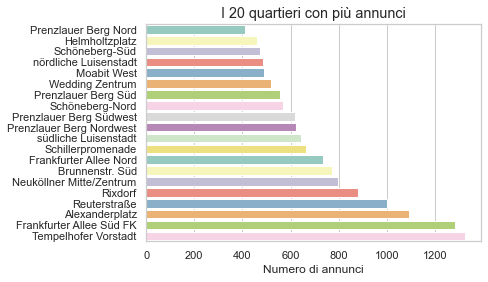

In [74]:
data = listing.neighbourhood.value_counts()
sns.set_theme(style="whitegrid")
sns.countplot(palette="Set3", y=listing['neighbourhood'], order = data.head(20).index[::-1])
plt.xlabel("Numero di annunci", fontsize = 'medium')
plt.ylabel('')
plt.title("I 20 quartieri più in voga", fontsize = 'large')

Possiamo notare che il quartiere 'Tempelhofer Vorstad' è il quartiere con il maggior numero di annunci e che __4 quartieri__ hanno più di 800 annunci.